# 서울시 코로나19 확진자 현황 데이터분석

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

In [9]:
df = pd.read_csv('./과제data/서울시 코로나19 확진자 현황.csv',encoding='euc-kr')

In [10]:
df

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
0,8966,11.30.,NaN,NaN,NaN,강북구,NaN,감염경로 조사중,NaN,NaN,NaN,2020-12-01 15:37:10,2020-12-01 15:37:10,Y
1,8965,11.30.,NaN,NaN,NaN,타시도,NaN,기타 확진자 접촉,NaN,NaN,NaN,2020-12-01 15:37:10,2020-12-01 15:37:10,Y
2,8964,11.30.,NaN,NaN,NaN,타시도,NaN,감염경로 조사중,NaN,NaN,NaN,2020-12-01 15:37:10,2020-12-01 15:37:10,Y
3,8963,11.30.,NaN,NaN,NaN,영등포구,NaN,서초구 사우나 관련,NaN,NaN,NaN,2020-12-01 15:37:10,2020-12-01 15:37:10,Y
4,8962,11.30.,NaN,NaN,NaN,영등포구,NaN,감염경로 조사중,NaN,NaN,NaN,2020-12-01 15:37:10,2020-12-01 15:37:10,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8961,5,1.31.,NaN,NaN,NaN,성북구,NaN,#5 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-12-01 15:36:52,2020-12-02 09:00:01,Y
8962,4,1.30.,NaN,NaN,NaN,마포구,중국 우한시,해외 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-12-01 15:36:52,2020-12-02 09:00:01,Y
8963,3,1.30.,NaN,NaN,NaN,종로구,NaN,#3 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-12-01 15:36:52,2020-12-02 09:00:01,Y
8964,2,1.30.,NaN,NaN,NaN,중랑구,중국 우한시,해외 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-12-01 15:36:52,2020-12-02 09:00:01,Y


### 구별 확진자수 구하기

In [52]:
# 피벗테이블
df.pivot_table('연번', '지역', aggfunc='count')

,연번
지역,
강남구,520
강동구,277
강북구,200
강서구,604
경기도,1
관악구,547
광진구,186
구로구,277
금천구,125


In [11]:
df['지역'].unique()

array(['강북구', '타시도', '영등포구', '노원구', '강동구', '광진구', '중랑구', '서초구', '강서구',
       '관악구', '은평구', '양천구', '구로구', '강남구', '중구', '기타', '마포구', '송파구', '용산구',
       '성북구', '도봉구', '서대문구', '금천구', '성동구', '동대문구', '동작구', '종로구', '경기도'],
      dtype=object)

In [12]:
city_list = []
for city in df['지역'].unique():
    a = len(df[df['지역'] == city])
    city_list.append((city, a))

In [13]:
city_list

[('강북구', 200),
 ('타시도', 432),
 ('영등포구', 309),
 ('노원구', 478),
 ('강동구', 277),
 ('광진구', 186),
 ('중랑구', 293),
 ('서초구', 472),
 ('강서구', 604),
 ('관악구', 547),
 ('은평구', 361),
 ('양천구', 316),
 ('구로구', 277),
 ('강남구', 520),
 ('중구', 110),
 ('기타', 234),
 ('마포구', 293),
 ('송파구', 611),
 ('용산구', 226),
 ('성북구', 464),
 ('도봉구', 319),
 ('서대문구', 261),
 ('금천구', 125),
 ('성동구', 223),
 ('동대문구', 312),
 ('동작구', 389),
 ('종로구', 126),
 ('경기도', 1)]

In [14]:
c_d = pd.DataFrame(city_list)
c_d.head()

,0,1
0,강북구,200
1,타시도,432
2,영등포구,309
3,노원구,478
4,강동구,277


In [15]:
c_d.rename({0 : '구별', 1:'확진자수'},axis=1, inplace=True)
c_d.set_index('구별', inplace=True)
c_d.head()

,확진자수
구별,
강북구,200
타시도,432
영등포구,309
노원구,478
강동구,277


### 지도에 나타내기

In [16]:
geo_path = './과제data/02. skorea_municipalities_geo_simple.json'
geo_data = json.load(open(geo_path, encoding='utf-8'))
map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles= 'Stamen Toner')
map.choropleth(geo_data = geo_data,
data= c_d['확진자수'],
columns= [c_d.index, c_d['확진자수']],
fill_color= 'PuRd',
key_on='feature.id')
title_html = '''
             <h3 align="center" style="font-size:20px"><b>서울시 코로나 구별 누적 확진자</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))
map

### 서울시 사망률 구하기

In [17]:
df['상태'].unique()

array([nan, '사망', '퇴원'], dtype=object)

In [18]:
con_list = []
for i in df['상태'].unique() :
    a = len(df[df['상태'] == i])
    con_list.append((i,a))

In [19]:
con_list

[(nan, 0), ('사망', 93), ('퇴원', 6620)]

In [20]:
# nan은 입원중?
del con_list[0]

In [21]:
# 사망률
con_list[0][1] / con_list[1][1]

0.014048338368580061

In [22]:
# 생각보다 너무많다.
df[df['상태'].isnull()]

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
0,8966,11.30.,NaN,NaN,NaN,강북구,NaN,감염경로 조사중,NaN,NaN,NaN,2020-12-01 15:37:10,2020-12-01 15:37:10,Y
1,8965,11.30.,NaN,NaN,NaN,타시도,NaN,기타 확진자 접촉,NaN,NaN,NaN,2020-12-01 15:37:10,2020-12-01 15:37:10,Y
2,8964,11.30.,NaN,NaN,NaN,타시도,NaN,감염경로 조사중,NaN,NaN,NaN,2020-12-01 15:37:10,2020-12-01 15:37:10,Y
3,8963,11.30.,NaN,NaN,NaN,영등포구,NaN,서초구 사우나 관련,NaN,NaN,NaN,2020-12-01 15:37:10,2020-12-01 15:37:10,Y
4,8962,11.30.,NaN,NaN,NaN,영등포구,NaN,감염경로 조사중,NaN,NaN,NaN,2020-12-01 15:37:10,2020-12-01 15:37:10,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,4735,9.14.,NaN,NaN,NaN,구로구,NaN,감염경로 조사중,NaN,NaN,이동경로 공개기간 경과,2020-12-01 15:37:01,2020-12-02 09:00:01,Y
4233,4733,9.14.,NaN,NaN,NaN,종로구,NaN,기타 확진자 접촉,NaN,NaN,이동경로 공개기간 경과,2020-12-01 15:37:01,2020-12-02 09:00:01,Y
4364,4602,9.11.,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,NaN,이동경로 공개기간 경과,2020-12-01 15:37:01,2020-12-02 09:00:01,Y
4767,4199,9.03.,NaN,NaN,NaN,기타,NaN,송파구 소재병원,NaN,NaN,이동경로 공개기간 경과,2020-12-01 15:37:00,2020-12-02 09:00:01,Y


### 구별 교회관련 확진자 구하기

In [23]:
chur = df[df['접촉력'].str.contains('교회')]
chur.head()

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
370,8596,11.28.,NaN,NaN,NaN,강남구,NaN,마포구 홍대새교회 관련,NaN,NaN,NaN,2020-12-01 15:37:09,2020-12-01 15:37:09,Y
562,8404,11.27.,NaN,NaN,NaN,강서구,NaN,마포구 홍대새교회 관련,NaN,NaN,NaN,2020-12-01 15:37:09,2020-12-01 15:37:09,Y
601,8365,11.27.,NaN,NaN,NaN,양천구,NaN,마포구 홍대새교회 관련,NaN,NaN,NaN,2020-12-01 15:37:08,2020-12-01 15:37:08,Y
616,8350,11.27.,NaN,NaN,NaN,서대문구,NaN,마포구 홍대새교회 관련,NaN,NaN,※ 자가격리 중 확진으로 서대문구 이동경로 없음 ※ #서-226 확진자 접촉,2020-12-01 15:37:08,2020-12-02 09:01:32,Y
621,8345,11.27.,NaN,NaN,NaN,금천구,NaN,마포구 홍대새교회 관련,NaN,NaN,NaN,2020-12-01 15:37:08,2020-12-01 15:37:08,Y


In [24]:
c_list = []
for i in chur['지역'].unique() :
    a = len(chur[chur['지역'] == i])
    c_list.append((i,a))

In [25]:
c_list

[('강남구', 39),
 ('강서구', 35),
 ('양천구', 28),
 ('서대문구', 41),
 ('금천구', 15),
 ('용산구', 22),
 ('기타', 8),
 ('마포구', 56),
 ('타시도', 65),
 ('종로구', 13),
 ('강북구', 44),
 ('관악구', 52),
 ('중구', 18),
 ('성북구', 146),
 ('중랑구', 27),
 ('구로구', 27),
 ('영등포구', 33),
 ('성동구', 9),
 ('은평구', 41),
 ('송파구', 94),
 ('동작구', 45),
 ('서초구', 32),
 ('노원구', 137),
 ('강동구', 36),
 ('도봉구', 24),
 ('광진구', 22),
 ('동대문구', 27)]

In [26]:
ch_d = pd.DataFrame(c_list)

In [27]:
ch_d.rename({0 : '구별', 1:'확진자수'},axis=1, inplace=True)
ch_d.set_index('구별', inplace=True)
ch_d.head()

,확진자수
구별,
강남구,39
강서구,35
양천구,28
서대문구,41
금천구,15


In [28]:
ch_d

,확진자수
구별,
강남구,39
강서구,35
양천구,28
서대문구,41
금천구,15
용산구,22
기타,8
마포구,56
타시도,65


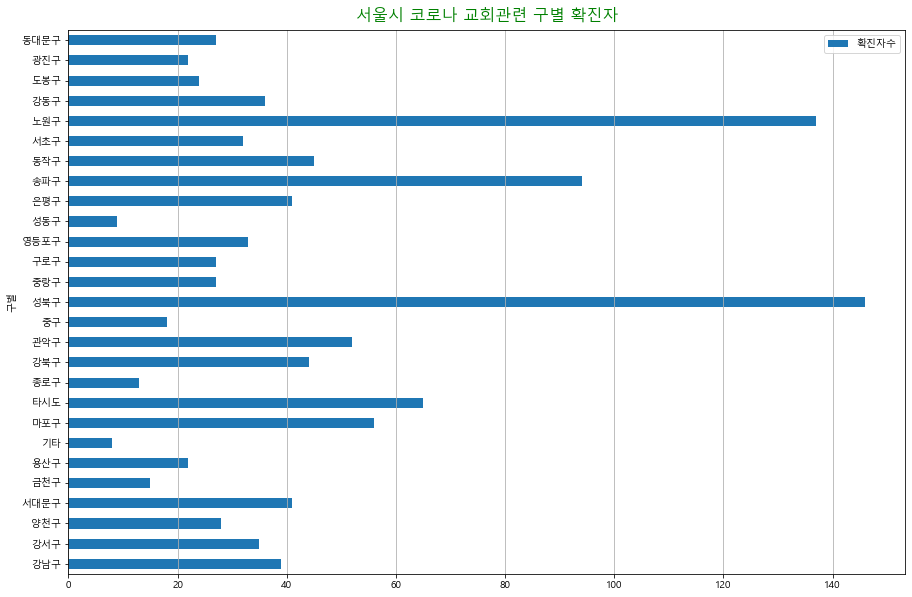

In [29]:
ch_d.plot.barh(figsize=(15,10))
plt.grid(True, axis='x')
plt.title('서울시 코로나 교회관련 구별 확진자', loc='center', pad=10, fontsize=16, color='g')
plt.show()

In [30]:
geo_path = './과제data/02. skorea_municipalities_geo_simple.json'
geo_data = json.load(open(geo_path, encoding='utf-8'))
map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles= 'Stamen Toner')
map.choropleth(geo_data = geo_data,
data= ch_d['확진자수'],
columns= [ch_d.index, ch_d['확진자수']],
fill_color= 'PuRd',
key_on='feature.id')
title_html = '''
             <h3 align="center" style="font-size:20px"><b>서울시 코로나 교회관련 구별 확진자</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))
map

### 구별 ,월별 확진자 구하기

In [31]:
df['확진일']

0       11.30.
1       11.30.
2       11.30.
3       11.30.
4       11.30.
         ...  
8961     1.31.
8962     1.30.
8963     1.30.
8964     1.30.
8965     1.24.
Name: 확진일, Length: 8966, dtype: object

In [32]:
df['확진월'] = df['확진일'].apply(lambda r:'08월' if r == '08.25.' else '0' + r.split('.')[0] + '월' if int(r.split('.')[0]) < 10  else r.split('.')[0] + '월' )
df['확진자'] = 1

In [33]:
df[df['확진월'] == '01월']

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부,확진월,확진자
8959,7,1.31.,NaN,NaN,NaN,종로구,NaN,#6 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-12-01 15:36:52,2020-12-02 09:00:01,Y,01월,1
8960,6,1.31.,NaN,NaN,NaN,종로구,NaN,#6 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-12-01 15:36:52,2020-12-02 09:00:01,Y,01월,1
8961,5,1.31.,NaN,NaN,NaN,성북구,NaN,#5 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-12-01 15:36:52,2020-12-02 09:00:01,Y,01월,1
8962,4,1.30.,NaN,NaN,NaN,마포구,중국 우한시,해외 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-12-01 15:36:52,2020-12-02 09:00:01,Y,01월,1
8963,3,1.30.,NaN,NaN,NaN,종로구,NaN,#3 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-12-01 15:36:52,2020-12-02 09:00:01,Y,01월,1
8964,2,1.30.,NaN,NaN,NaN,중랑구,중국 우한시,해외 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-12-01 15:36:52,2020-12-02 09:00:01,Y,01월,1
8965,1,1.24.,NaN,NaN,NaN,강서구,중국 우한시,해외 접촉,NaN,퇴원,이동경로 공개기간 경과,2020-12-01 15:36:52,2020-12-02 09:00:01,Y,01월,1


In [43]:
pdf1 = pd.pivot_table(df,               
                     index = '지역',    
                     columns = '확진월',  
                     values = '확진자',   
                     aggfunc = 'sum')
pdf1.head()

확진월,01월,02월,03월,04월,05월,06월,07월,08월,09월,10월,11월
지역,,,,,,,,,,,
강남구,NaN,8.0,36.0,21.0,11.0,7.0,15.0,89.0,82.0,88.0,163.0
강동구,NaN,4.0,6.0,3.0,11.0,11.0,14.0,94.0,42.0,19.0,73.0
강북구,NaN,NaN,5.0,NaN,9.0,10.0,4.0,85.0,31.0,15.0,41.0
강서구,1.0,1.0,20.0,4.0,20.0,33.0,25.0,115.0,64.0,22.0,299.0
경기도,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [44]:
pdf1.fillna(0)

확진월,01월,02월,03월,04월,05월,06월,07월,08월,09월,10월,11월
지역,,,,,,,,,,,
강남구,0.0,8.0,36.0,21.0,11.0,7.0,15.0,89.0,82.0,88.0,163.0
강동구,0.0,4.0,6.0,3.0,11.0,11.0,14.0,94.0,42.0,19.0,73.0
강북구,0.0,0.0,5.0,0.0,9.0,10.0,4.0,85.0,31.0,15.0,41.0
강서구,1.0,1.0,20.0,4.0,20.0,33.0,25.0,115.0,64.0,22.0,299.0
경기도,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
관악구,0.0,4.0,30.0,9.0,16.0,59.0,27.0,109.0,136.0,86.0,71.0
광진구,0.0,1.0,5.0,2.0,6.0,3.0,5.0,74.0,34.0,11.0,45.0
구로구,0.0,1.0,33.0,1.0,6.0,45.0,5.0,60.0,32.0,22.0,72.0
금천구,0.0,1.0,11.0,0.0,3.0,17.0,7.0,34.0,20.0,5.0,27.0


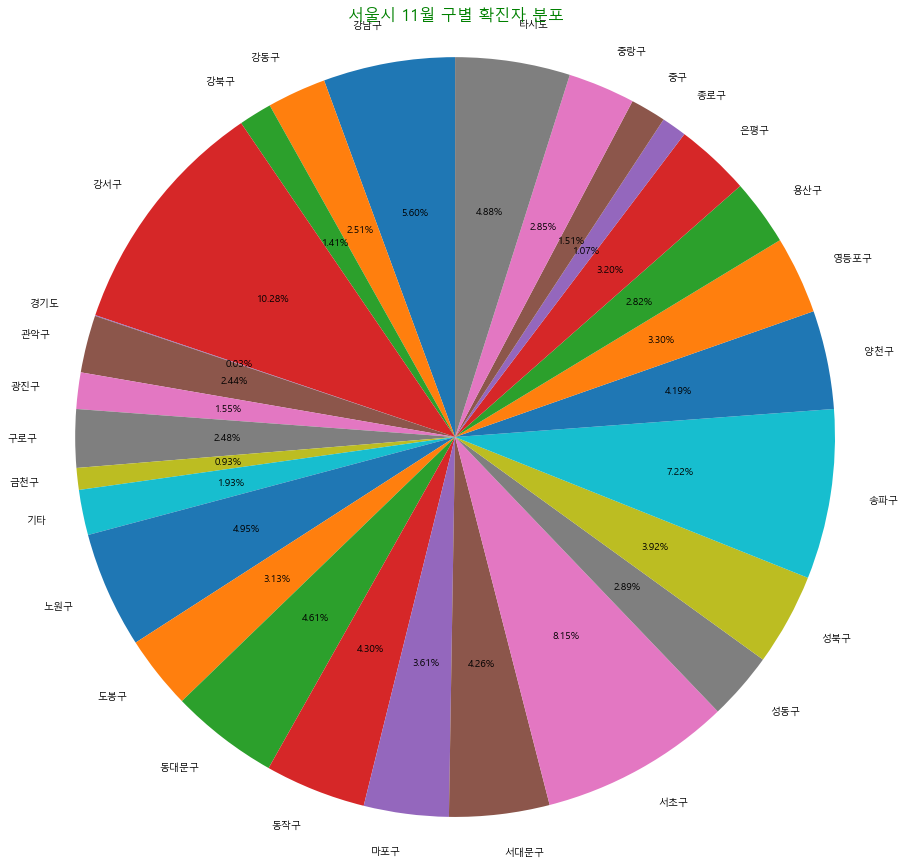

In [36]:
plt.figure(figsize=(15,15))
label = pdf1.index
plt.pie(pdf1['11월'],autopct='%.2f%%',labels=label,startangle=90)
plt.axis('equal')
plt.title('서울시 11월 구별 확진자 분포', loc='center', pad=10, fontsize=16, color='g')
plt.show()

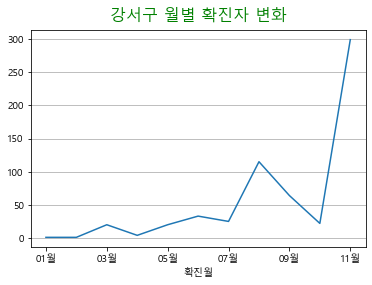

In [37]:
pdf1.loc['강서구'].plot()
plt.title('강서구 월별 확진자 변화', loc='center', pad=10, fontsize=16, color='g')
plt.grid(True, axis='y')
plt.show()

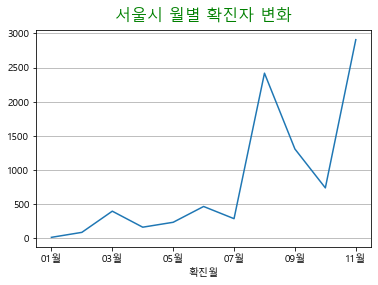

In [38]:
df['확진자'].groupby(df['확진월']).sum().plot()
plt.title('서울시 월별 확진자 변화', loc='center', pad=10, fontsize=16, color='g')
plt.grid(True, axis='y')
plt.show()